In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def gerar_ciclos(n_exemplos, min_n=3, max_n=15):
    grafos = []
    for _ in range(n_exemplos):
        n = np.random.randint(min_n, max_n + 1)
        G = nx.cycle_graph(n)
        grafos.append(G)
    return grafos


# --- GCN Layer ---
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, A_hat, X):
        return self.linear(torch.matmul(A_hat, X))

# --- VGAE ---
class VGAE(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.gcn1 = GCNLayer(in_dim, hidden_dim)
        self.gcn2_mu = GCNLayer(hidden_dim, latent_dim)
        self.gcn2_logvar = GCNLayer(hidden_dim, latent_dim)

        self.decoder_fc1 = nn.Linear(latent_dim * 2, latent_dim * 2)
        self.decoder_fc2 = nn.Linear(latent_dim * 2, 1)

    def encode(self, A_hat, X):
        H = F.leaky_relu(self.gcn1(A_hat, X))
        mu = self.gcn2_mu(A_hat, H)
        logvar = self.gcn2_logvar(A_hat, H)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, Z):
        N = Z.size(0)
        rows = []
        for i in range(N):
            for j in range(N):
                z_ij = torch.cat([Z[i], Z[j]])
                h = F.leaky_relu(self.decoder_fc1(z_ij))
                out = torch.sigmoid(self.decoder_fc2(h))
                rows.append(out)
        return torch.stack(rows).view(N, N)

    def forward(self, A_hat, X):
        mu, logvar = self.encode(A_hat, X)
        Z = self.reparameterize(mu, logvar)
        A_pred = self.decode(Z)
        return A_pred, mu, logvar

# --- Treinamento ---
def preparar_adjacencia(G):
    A = nx.to_numpy_array(G)
    np.fill_diagonal(A, 1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(A.sum(axis=1) + 1e-10))
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32), torch.tensor(A, dtype=torch.float32)

grafos = gerar_ciclos(10000, 10, 25)
model = VGAE(in_dim=1, hidden_dim=8, latent_dim=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for G in grafos:
        A_hat, A = preparar_adjacencia(G)
        N = A.shape[0]
        X = torch.ones((N, 1))  # Feature constante: h = 1

        A_pred, mu, logvar = model(A_hat, X)

        recon_loss = F.binary_cross_entropy(A_pred, A)
        kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(grafos):.4f}")

Epoch 1, Loss: 0.4274
Epoch 11, Loss: 0.4141
Epoch 21, Loss: 0.3931
Epoch 31, Loss: 0.3908
Epoch 41, Loss: 0.3904
Epoch 51, Loss: 0.3905
Epoch 61, Loss: 0.3901
Epoch 71, Loss: 0.3898
Epoch 81, Loss: 0.3901
Epoch 91, Loss: 0.3901
Epoch 100, Loss: 0.3895


In [5]:
# Supondo que latent_dim = 4 (como no modelo treinado)
latent_dim = 4
num_novos_grafos = 5  # Número de grafos a serem gerados
num_nos = 10  # Número de nós em cada novo grafo (pode ser fixo ou variável)

# Amostra vetores latentes de uma distribuição normal padrão
Z_novos = torch.randn(num_nos, latent_dim)  # Shape: (num_nos, latent_dim)

with torch.no_grad():  # Desativa cálculos de gradiente (não é treinamento)
    A_pred = model.decode(Z_novos)  # Shape: (num_nos, num_nos)

threshold = 0.5  
A_binaria = (A_pred > threshold).float()  

In [6]:
# Converte para numpy e remove autoloops (opcional)
A_numpy = A_binaria.numpy()
np.fill_diagonal(A_numpy, 0)  

# Cria o grafo
G_novo = nx.from_numpy_array(A_numpy)

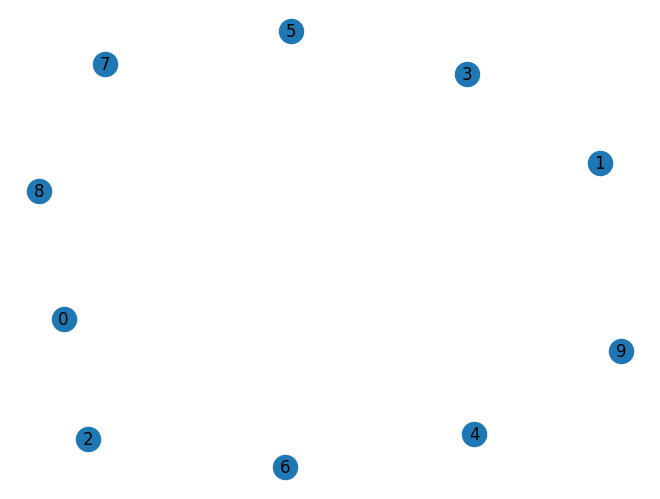

In [7]:
nx.draw(G_novo, with_labels=True)
plt.show()

In [8]:
torch.save(model.state_dict(), "cycle_torch.pth")